## Problem 2
### Milad Heidari
### Student Number: 98101469

In [1]:
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, examples, labels, transform=None, target_transform=None):
        self.examples = examples
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        example = self.examples.iloc[idx, :]
        label = self.labels.iloc[idx]
        if self.transform is not None:
            example = self.transform(example)
        if self.target_transform is not None:
            label = self.target_transform(label)
            
        return example, label

In [4]:
# creating training and test set
df_train = pd.read_csv('data/Q3_train.csv')
df_test = pd.read_csv('data/Q3_test.csv')

train_set = CustomDataset(
    df_train.iloc[:, 1:],
    df_train.iloc[:, 0],
    transform=lambda x: torch.tensor(x).reshape((int(np.sqrt(len(x))), -1)),
)

test_set = CustomDataset(
    df_test.iloc[:, 1:],
    df_test.iloc[:, 0],
    transform=lambda x: torch.tensor(x).reshape((int(np.sqrt(len(x))), -1)),
)

#### A)

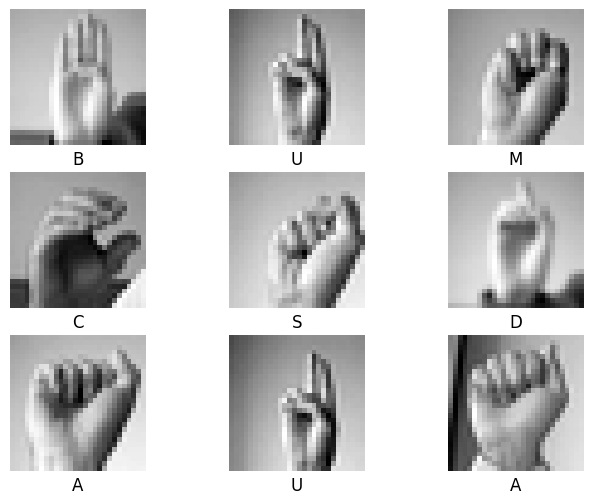

In [5]:
sample_dataloader = DataLoader(train_set, shuffle=True)
data_iterator = iter(sample_dataloader)

fig = plt.figure(figsize=(8, 6))
for i in range(1, 10):
    X, y = next(data_iterator)
    ax = fig.add_subplot(3, 3, i)
    ax.set_axis_off()
    ax.imshow(X.squeeze(), cmap='gray')
    ax.set_title(chr(65 + y), y=-0.2)

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 60),
            nn.ReLU(),
            nn.Linear(60, 26),
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x

In [7]:
# create an instance of the model defined above
model = NeuralNetwork().to(device)
model.train()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=26, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [8]:
# setting hyperparameters
learning_rate = 1e-5
batch_size = 64
epochs = 25

In [9]:
# initialize the cost function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, train_losses=None, save_losses=False):
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if save_losses:
            if batch_num % 100 == 0:
                train_losses.append(loss.item())
        
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn, test_losses=None, save_losses=False):
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
            
            if save_losses:
                if batch_num % 100 == 0:
                    test_losses.append(loss.item())
        
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [11]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
train_losses = []
test_losses = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer, train_losses=train_losses, save_losses=True)
    test_loop(test_dataloader, model, loss_fn, test_losses=test_losses, save_losses=True)
    print()

epoch 1 ==================================================
train_loss: 2.8840887546539307
Train Accuracy: 4.36%
Test Accuracy: 3.42%

epoch 2 ==================================================
train_loss: 2.781796455383301
Train Accuracy: 4.36%
Test Accuracy: 3.42%

epoch 3 ==================================================
train_loss: 2.736419677734375
Train Accuracy: 4.36%



KeyboardInterrupt



In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)